In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import preprocessor as p


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis #https://pypi.org/project/pyLDAvis/
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [23]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use', 'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there',
                   'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 
                   'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself',
                   'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
                   'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 
                   'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their',
                   'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 
                   'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 
                   'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 
                   'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only',
                   'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 
                   'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than', 'th',
                   'go', 'whos', 'ive', 'etc', ])

df = pd.read_csv("../tweets_sentiments4lda.csv", index_col=0)

# Convert to list
data = df.text.values.tolist()

## cleaning
p.set_options(p.OPT.EMOJI, p.OPT.SMILEY)
data = [p.clean(sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



In [24]:
pprint(data[:1])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

['A great try by @seanspicer. We are all proud of you!']
[['great', 'try', 'by', 'seanspicer', 'we', 'are', 'all', 'proud', 'of', 'you']]


In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
print(data_words_nostops)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


['great', 'try', 'by', 'seanspicer', 'we', 'are', 'all', 'proud', 'of', 'you']
[['great', 'try', 'seanspicer', 'proud'], ['vote', 'sean', 'spicer', 'dancing', 'stars', 'great', 'loyal', 'guy', 'working', 'hard', 'quarterfinals', 'way', 'sean', 'maga', 'kag'], ['ukraine', 'impeachment', 'subverting', 'democracy', 'true', 'led', 'angry', 'dishonest', 'people', 'hate', 'must', 'hate', 'country'], ['want', 'impeachable', 'offense', 'good', 'luck', 'foxnews'], ['president', 'september', 'give', 'aid', 'ukraine', 'gets', 'september', 'weeks', 'deadline', 'give', 'ally', 'aid', 'joe', 'biden', 'investigated', 'remember', 'get', 'aid', 'get', 'nothing', 'return', 'democrats'], ['schiff', 'dems', 'created', 'whole', 'thing', 'reverse', 'engineer', 'vowing', 'impeach', 'three', 'years', 'listen', 'want', 'foxnews'], ['order', 'continue', 'transparent', 'president', 'history', 'releasing', 'sometime', 'week', 'transcript', 'first', 'therefore', 'important', 'phone', 'call', 'president', 'ukraine'

In [26]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
# mapping of [wordid, wordfreq] to see what word an id corresponds to pass id as key
print(id2word[0])


[['great', 'try', 'seanspicer', 'proud']]
[[(0, 1), (1, 1), (2, 1), (3, 1)]]
great


In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [43]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(18,
  '0.000*"sore" + 0.000*"mtg" + 0.000*"mccathyism" + 0.000*"prestige" + '
  '0.000*"bezos" + 0.000*"degraded" + 0.000*"extinct" + 0.000*"lobbying" + '
  '0.000*"unregistered" + 0.000*"yorker"'),
 (19,
  '0.000*"sore" + 0.000*"mtg" + 0.000*"mccathyism" + 0.000*"prestige" + '
  '0.000*"bezos" + 0.000*"degraded" + 0.000*"extinct" + 0.000*"lobbying" + '
  '0.000*"unregistered" + 0.000*"yorker"'),
 (0,
  '0.301*"welcome" + 0.000*"yorker" + 0.000*"widest" + 0.000*"mccathyism" + '
  '0.000*"prestige" + 0.000*"bezos" + 0.000*"degraded" + 0.000*"extinct" + '
  '0.000*"lobbying" + 0.000*"unregistered"'),
 (17,
  '0.140*"fake" + 0.130*"focus" + 0.084*"judge" + 0.075*"serve" + '
  '0.061*"person" + 0.047*"evidence" + 0.010*"earth" + 0.009*"confirm" + '
  '0.002*"conservative" + 0.000*"smear"'),
 (9,
  '0.371*"back" + 0.160*"lie" + 0.031*"pelosi" + 0.002*"schiff" + '
  '0.000*"extinct" + 0.000*"unregistered" + 0.000*"sore" + 0.000*"lobbying" + '
  '0.000*"bezos" + 0.000*"degraded"'),
 (14,
  

In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/sierrawulfson/opt/anaconda3/envs/CS6220/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.232490 -0.361658       1        1  6.754140
7     -0.182136  0.213261       2        1  6.493464
11    -0.125361  0.049510       3        1  6.141727
26    -0.168222  0.128273       4        1  5.576833
15    -0.045532  0.007362       5        1  4.877051
1     -0.068047  0.014424       6        1  4.798392
28    -0.004799 -0.000977       7        1  4.736259
4     -0.061469  0.012044       8        1  4.674216
6     -0.060327  0.011761       9        1  4.651299
21    -0.044221  0.007086      10        1  4.401113
29    -0.022447  0.002128      11        1  4.122781
5     -0.030056  0.003814      12        1  3.819252
24    -0.062569  0.012533      13        1  3.683931
3     -0.039902  0.006082      14        1  3.656248
8      0.014453 -0.003755      15        1  3.599418
2      0.025417 -0.005062      16        1  3.569851
20     0.046790 -0.007340      17        1  3.294513
10    -0.026012  0.003084      18        1  3.217075
16    -0.057367  0.010939      19        1  2.885851
23     0.002609 -0.002172      20        1  2.510372
25     0.085612 -0.010104      21        1  2.487319
22     0.064804 -0.008895      22        1  2.364131
12     0.077376 -0.009713      23        1  2.147098
27     0.044574 -0.007041      24        1  2.051817
14     0.126416 -0.011699      25        1  1.315539
9      0.135854 -0.011782      26        1  1.025609
17     0.137354 -0.011808      27        1  0.964057
0      0.155241 -0.010873      28        1  0.108007
18     0.157229 -0.009711      29        1  0.036319
19     0.157229 -0.009711      30        1  0.036319, topic_info=     Category         Freq        Term        Total  loglift  logprob
0     Default  5586.000000       great  5586.000000  30.0000  30.0000
174   Default  2009.000000       thank  2009.000000  29.0000  29.0000
25    Default  2677.000000      people  2677.000000  28.0000  28.0000
263   Default  2415.000000        time  2415.000000  27.0000  27.0000
18    Default  1951.000000     country  1951.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
3887  Topic30     0.004884     hurting     2.281635   1.7738  -9.3569
3886  Topic30     0.004884        euro     2.281635   1.7738  -9.3569
3885  Topic30     0.004884  depreciate     2.281635   1.7738  -9.3569
3884  Topic30     0.004884     central     2.281635   1.7738  -9.3569
3883  Topic30     0.004884        view     2.281635   1.7738  -9.3569

[1761 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
252      11  0.984626            able
102       6  0.836398  accomplishment
97       18  0.993470             act
286      23  0.835232     adam_schiff
540      17  0.993751           agree
...     ...       ...             ...
177       2  0.997273           world
266      11  0.998709           would
313       1  0.993778           wrong
58       16  0.998940            year
333      10  0.980686             yet

[352 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 8, 12, 27, 16, 2, 29, 5, 7, 22, 30, 6, 25, 4, 9, 3, 21, 11, 17, 24, 26, 23, 13, 28, 15, 10, 18, 1, 19, 20])

In [51]:
# Topics range
min_topics = 2
max_topics = 35
step_size = 1
numtopics = range(min_topics, max_topics, step_size)
# Alpha parameter
alphas = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
betas = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

for nt in numtopics:
    for a in alphas:
        for b in betas:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=nt,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta = b,
                                           per_word_topics=True)
            # Print the Keyword in the 10 topics
            pprint(lda_model.print_topics())
            doc_lda = lda_model[corpus]
            print('nt', nt)
            print('a',a)
            print('b', b)
            # Compute Perplexity
            print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

            # Compute Coherence Score
            coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
            coherence_lda = coherence_model_lda.get_coherence()
            print('\nCoherence Score: ', coherence_lda)


[(0,
  '0.083*"thank" + 0.068*"never" + 0.056*"great" + 0.045*"do" + 0.038*"work" + '
  '0.033*"vote" + 0.030*"job" + 0.027*"today" + 0.026*"presidential" + '
  '0.024*"president"'),
 (1,
  '0.042*"great" + 0.024*"people" + 0.023*"make" + 0.021*"time" + '
  '0.020*"medium" + 0.020*"good" + 0.019*"big" + 0.018*"country" + 0.017*"day" '
  '+ 0.017*"president"')]
nt 2
a 0.01
b 0.01

Perplexity:  -67.87864616490869

Coherence Score:  0.41762729083919914
[(0,
  '0.035*"great" + 0.019*"thank" + 0.012*"today" + 0.010*"forget" + '
  '0.010*"never" + 0.010*"america" + 0.009*"day" + 0.008*"president" + '
  '0.008*"make" + 0.008*"together"'),
 (1,
  '0.011*"election" + 0.010*"medium" + 0.010*"time" + 0.009*"not" + '
  '0.009*"good" + 0.008*"people" + 0.007*"get" + 0.007*"trump" + '
  '0.007*"fake_new" + 0.007*"say"')]
nt 2
a 0.01
b 0.31

Perplexity:  -8.168790764977446


KeyboardInterrupt: 

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [45]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet'
# update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(3,
  [('speak', 0.02970616725863739),
   ('florida', 0.024216984178237002),
   ('announce', 0.02195673232160155),
   ('safe', 0.02050371327090733),
   ('morning', 0.01614465611882467),
   ('secretary', 0.01566031643525993),
   ('japan', 0.01469163706813045),
   ('prime_minister', 0.014045850823377462),
   ('general', 0.013722957701000968),
   ('close', 0.013238618017436228)]),
 (19,
  [('good', 0.14184965539349254),
   ('thing', 0.05690014425388684),
   ('history', 0.049527167815355023),
   ('happen', 0.04776406475396698),
   ('year', 0.03910883154351659),
   ('long', 0.034781214938291394),
   ('tonight', 0.025965699631351178),
   ('interview', 0.02452316076294278),
   ('true', 0.023401186087514025),
   ('political', 0.02308062189453438)]),
 (12,
  [('american', 0.11062225015713388),
   ('america', 0.08705216844751729),
   ('put', 0.03205531112507857),
   ('worker', 0.02199874292897549),
   ('party', 0.019798868636077938),
   ('proud', 0.01744186046511628),
   ('power', 0.01524198617

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [48]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

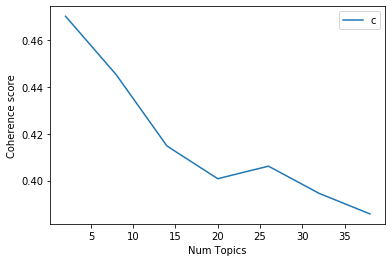

In [49]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4703
Num Topics = 8  has Coherence Value of 0.4452
Num Topics = 14  has Coherence Value of 0.4147
Num Topics = 20  has Coherence Value of 0.4008
Num Topics = 26  has Coherence Value of 0.4061
Num Topics = 32  has Coherence Value of 0.3945
Num Topics = 38  has Coherence Value of 0.3857


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()